## Creating the coordinate files for the labeled subset of our network

- In this notebook, I am creating a labelled subset of our network. Markers are labeled as high or low based on expert knowledge. This is subsequently to be used as input in the CORG method for model validation.
- Secondly, I am fitting the CA pipeline on all models. All coordinate files for the subsets are saved in separate folders. 
- Important to note, the CA is performed with all markers available. It is only in the CORG method that the labeled markers are relevant

In [16]:
# Standard library imports
import sys

# Third party imports
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import seaborn as sns
import numpy as np
import prince
from networkx.algorithms import bipartite
from matplotlib.patches import Patch
import community as community_louvain
from netgraph import Graph

# Local application imports
sys.path.insert(0, '../Utility files')
from corg import DiscoverDimension, BenchmarkDimension
import utils2
from utils2 import *
import graphfunk
from graphfunk import *
import ca_pipeline
from ca_pipeline import PipelineCorAnalysis

### 1. Create the labeled subset

Create an empty csv file to fill in manualy (High vs. Low SES)

- The data used to create the labeled df contains a row for each follower relationship a brand has. It includes the original type column, as well as the changed column (condensed from 12 to 4 types.)
- Additionally, it has been filtered to only include markers with more than 100 followers

In [ ]:

# # load data
# path = '/home/livtollanes/NewData/french/french_edgelist_marker_threshold.csv'

# req_cols = ['marker_id', 'follower_id', 'twitter_name','followers','french_followers', 'type', 'type2']
# dtypes = {'marker_id': 'object',
#           'follower_id': 'object',
#           'twitter_name': 'object',
#           'followers': 'int64',
#           'french_followers': 'int64',
#           'type': 'object',
#           'type2': 'object'}


# edgelist_CORG = pd.read_csv(path, usecols=req_cols, dtype=dtypes)

# #Separate my data frame into dictionary of types
# def create_dict(df, key_col, value_col):
#     unique_df = df.drop_duplicates(subset=[key_col, value_col])
#     return unique_df.groupby(key_col)[value_col].apply(list).to_dict()


# df_dict = create_dict(edgelist_CORG, 'type', 'twitter_name')
# df_dict2 = create_dict(edgelist_CORG, 'type2', 'twitter_name')


# for key, value in df_dict.items():
#     value = list(set(value))
#     print(f"Key: {key}")
#     print(f"Value: {value}\n")



# # Create a csv file to use for labeling 
# rows = []
# for key, values in df_dict.items():
#     for value in values:
#         row = {'type': key, 'twitter_name': value, 'high': '', 'low': ''}
#         rows.append(row)

# # Now we write the rows to a CSV file
# keys = ['type', 'twitter_name', 'high', 'low']

# with open('/home/livtollanes/10.jan-thesis/labeldata/labeled_markers_empty.csv', 'w', newline='') as output_file:
#     dict_writer = csv.DictWriter(output_file, keys)
#     dict_writer.writeheader()
#     dict_writer.writerows(rows)

Load filled label data

In [2]:
# load data (this is the full list of markers together with the labels) 223 markers
path = '/home/livtollanes/10.jan-thesis/labeldata/filled_labels_markers.csv'

req_cols = ['type', 'twitter_name', 'high', 'low', 'other']
dtypes = {'type': 'object',
          'twitter_name': 'object',
          'high': 'object',
          'low': 'object',
          'other': 'object'}

labels_hl = pd.read_csv(path, usecols=req_cols, dtype=dtypes)

Now, reformat the filled in label df

I put 0: low, 1: high, NA: other

In [8]:
# Create the labeled marker df to input to the CORG method

# Create a copy of labels_hl
labels_CORG = labels_hl.copy()

# Create 'SES' column
labels_CORG['label'] = np.where(labels_CORG['high'] == '1', '1', 
                              np.where(labels_CORG['low'] == '1', '0', 'NA'))


#0: low, 1: high, NA: other

# Drop the rows where 'SES' is 'drop'
labels_CORG = labels_CORG[labels_CORG['label'] != 'drop']

# Keep only 'twitter_name' and 'SES' columns
labels_CORG = labels_CORG[['twitter_name', 'type', 'label']]

In [16]:
labels_CORG['label'].value_counts() # 22 H, 14 L. Looks correct

label
NA    187
1      22
0      14
Name: count, dtype: int64

In [19]:

# load full marker edgelist data. All follower relationships
path = '/home/livtollanes/NewData/french/french_edgelist_marker_threshold.csv'

req_cols = ['marker_id', 'follower_id', 'twitter_name','followers','french_followers', 'type', 'type2']
dtypes = {'marker_id': 'object',
          'follower_id': 'object',
          'twitter_name': 'object',
          'followers': 'int64',
          'french_followers': 'int64',
          'type': 'object',
          'type2': 'object'}


all = pd.read_csv(path, usecols=req_cols, dtype=dtypes)



In [21]:
all.head()

,marker_id,follower_id,twitter_name,type,followers,french_followers,type2
0,19976004,1193293102162862080,Mediapart,media,3079643,64182,information
1,19976004,2884619299,Mediapart,media,3079643,64182,information
2,19976004,782999494703054848,Mediapart,media,3079643,64182,information
3,19976004,124458686,Mediapart,media,3079643,64182,information
4,19976004,2960220189,Mediapart,media,3079643,64182,information


In [23]:
labels_CORG_subset = labels_CORG[['twitter_name', 'label']]
all_labeled = all.merge(labels_CORG_subset, how='left', on='twitter_name')

In [30]:
#Save the labeled edgelist to csv in /home/livtollanes/NewData
all_labeled.to_csv('/home/livtollanes/NewData/french/labeled_edgelist_hl.csv', index=False)

### 2. Obtaining CA coordinate files for all models 

#### 2.1 Creating models

In [12]:
# load the labeled marker edgelist (labeled markers and their followers). This df still contains all markers, but only some are labeled
path = '/home/livtollanes/NewData/french/labeled_edgelist_hl.csv'

req_cols = ['marker_id', 'follower_id', 'twitter_name','followers','french_followers', 'type', 'type2', 'label']
dtypes = {'marker_id': 'object',
          'follower_id': 'object',
          'twitter_name': 'object',
          'followers': 'int64',
          'french_followers': 'int64',
          'type': 'object',
          'type2': 'object',
          'label': 'object'}


m1_df = pd.read_csv(path, usecols=req_cols, dtype=dtypes)

In [17]:
# create models for different subsets of the data - only including certain marker configurations
m2_df = m1_df[m1_df['type'] != 'party']
m3_df = m1_df[~m1_df['type'].isin(['media', 'party', 'universities'])]
m4_df = m1_df[~m1_df['type'].isin(['media', 'party', 'universities', 'clubs de football'])]
m5_df = m1_df[~m1_df['type'].isin(['media', 'party', 'universities', 'clubs de football', 'luxe vetements et malls'])]

selected_twitter_names = ['Dior', 'CHANEL', 'LouisVuitton', 'YSL', 'Cartier', 'Hermes_Paris', 'VeuveClicquot']
m6_df = m1_df[~((m1_df['type'] == 'party') | 
                (m1_df['type'] == 'media') |
                (m1_df['type'] == 'universities') | 
                (m1_df['type'] == 'clubs de football') |
                ((m1_df['type'] == 'luxe vetements et malls') & (m1_df['twitter_name'].isin(selected_twitter_names))))]


m7_df = m1_df[m1_df['type'].isin(['chain restaurants', 'commerce', 'grande distribution', 'sport', 'luxe vetements et malls'])]
m8_df = m1_df[m1_df['type'].isin(['magazine', 'media'])]
m9_df = m1_df[m1_df['type'].isin(['universities', 'ecoles de commerce', 'Lycées professionels'])]


In [62]:
utils2.count_unique_labels(m10_df)


label
1    3
0    1
Name: count, dtype: int64

#### 2.2 Fitting CA

Here, I fit the CA on each of the models. Each time, all markers included in a given model is being used. Resultantly, the coordinate file sthat are created hold for the full graph. The labelling of the markers comes into play in the CORG step. 

In [65]:
import ca_pipeline
import importlib

Starting graph checks...
Number of nodes: 115302
Edge number is sane - matches the number of rows in the inputted edgelist
Is the graph connected? True
Number of connected components: 1
Size of largest connected component: 115302


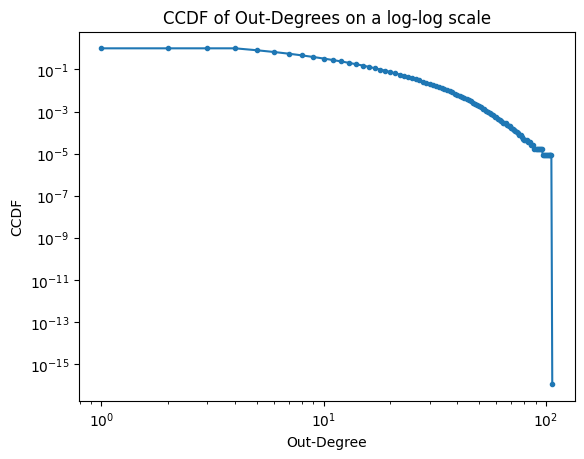

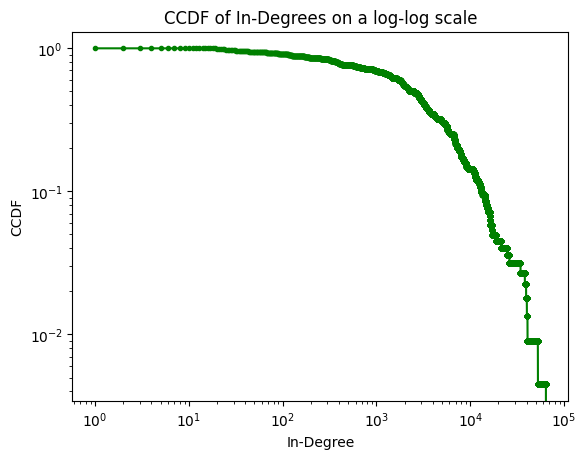

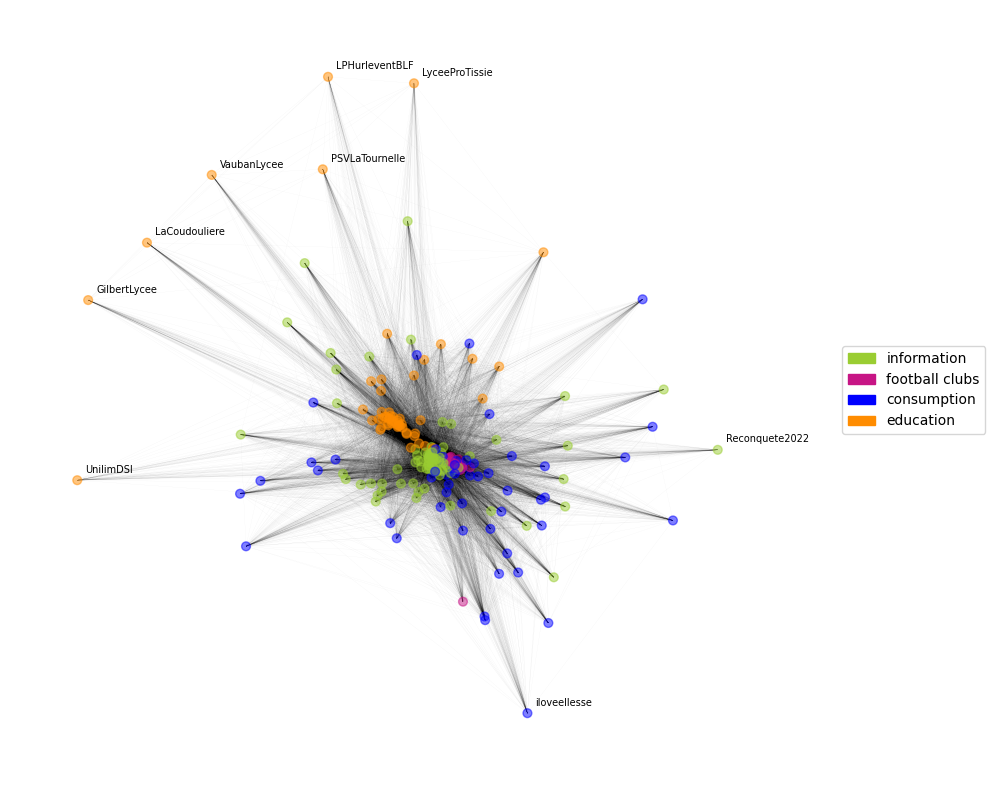

Number of communities: 4
Graph checks complete. Starting CA fitting pipeline...
Creating contingency table...
Performing CA analysis. Might take some time...
Plotting variance...


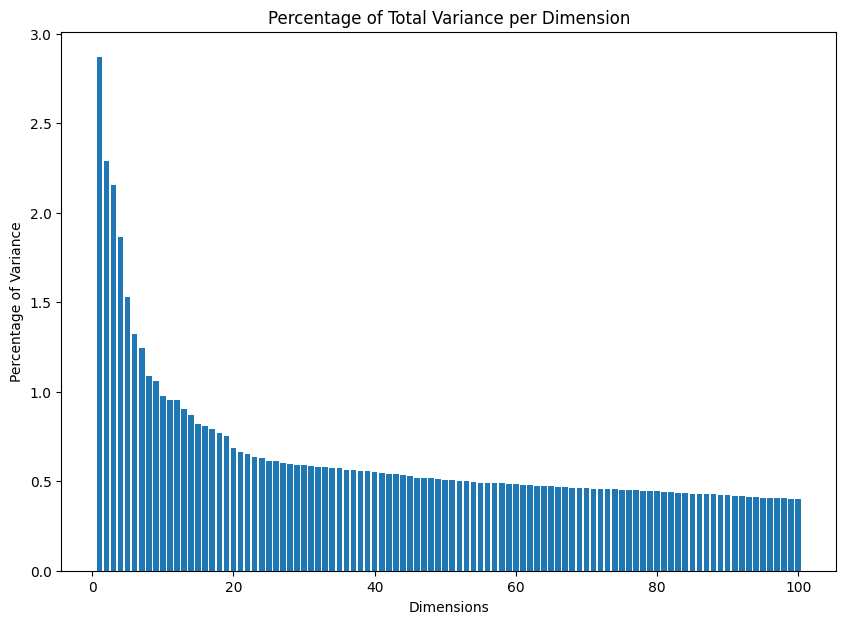

CA pipeline complete.


In [67]:
#m1
importlib.reload(ca_pipeline)
subset_name = 'm1'
labeled = ca_pipeline.PipelineCorAnalysis(m1_df, subset_name)
path = '/home/livtollanes/NewData/coordinates'
labeled.run_all(path)

Starting graph checks...
Number of nodes: 115245
Edge number is sane - matches the number of rows in the inputted edgelist
Is the graph connected? True
Number of connected components: 1
Size of largest connected component: 115245


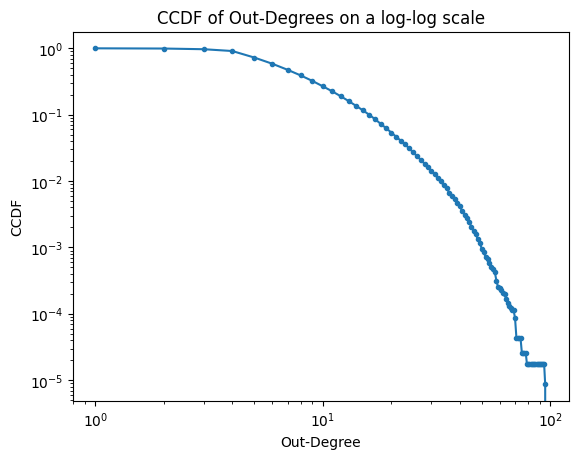

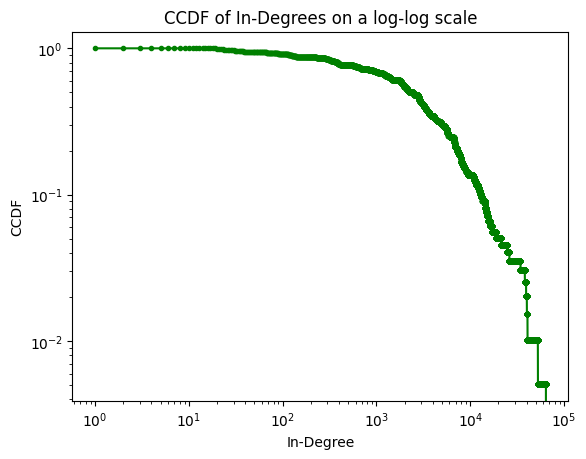

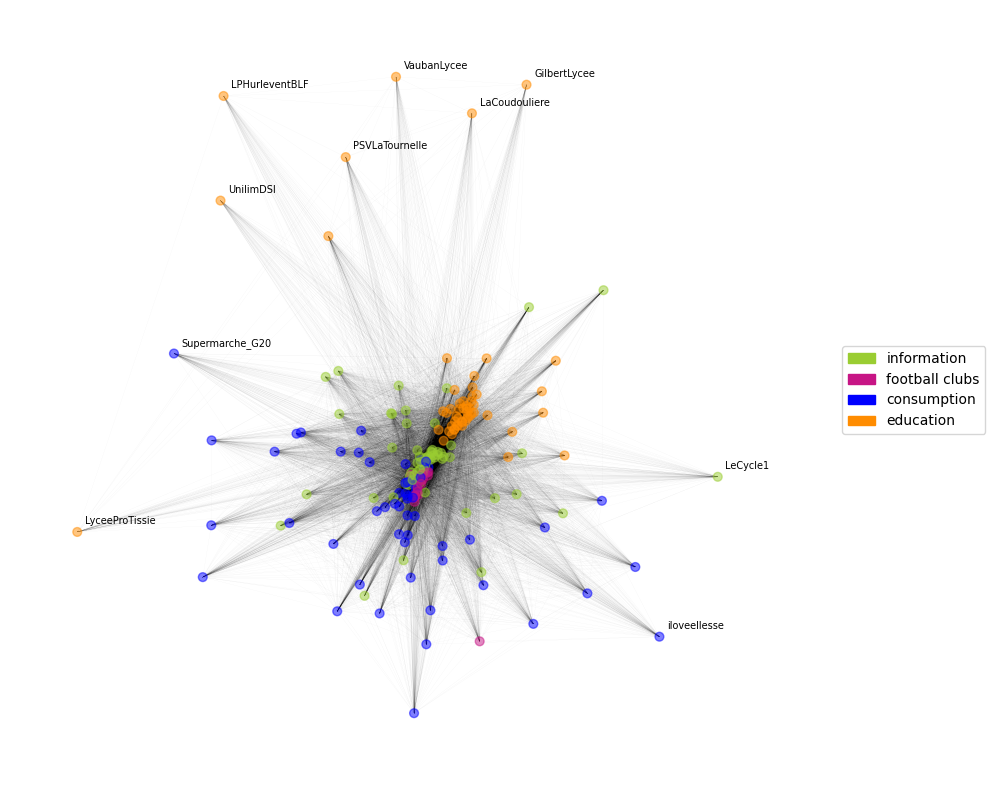

Number of communities: 4
Graph checks complete. Starting CA fitting pipeline...
Creating contingency table...
Performing CA analysis. Might take some time...
Plotting variance...


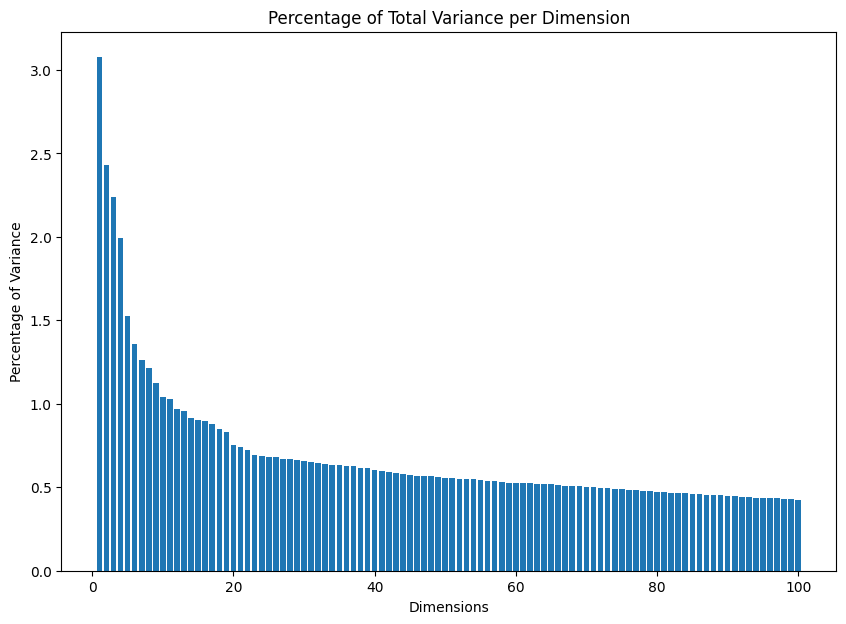

CA pipeline complete.


In [68]:
#m2
importlib.reload(ca_pipeline)
subset_name = 'm2'
labeled = ca_pipeline.PipelineCorAnalysis(m2_df, subset_name)
path = '/home/livtollanes/NewData/coordinates'
labeled.run_all(path)

Starting graph checks...
Number of nodes: 105711
Edge number is sane - matches the number of rows in the inputted edgelist
Is the graph connected? True
Number of connected components: 1
Size of largest connected component: 105711


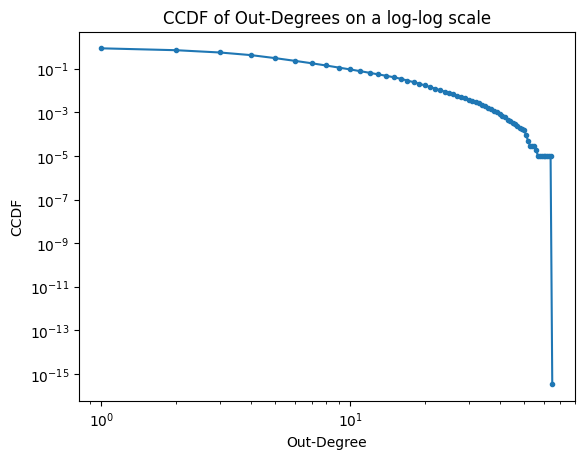

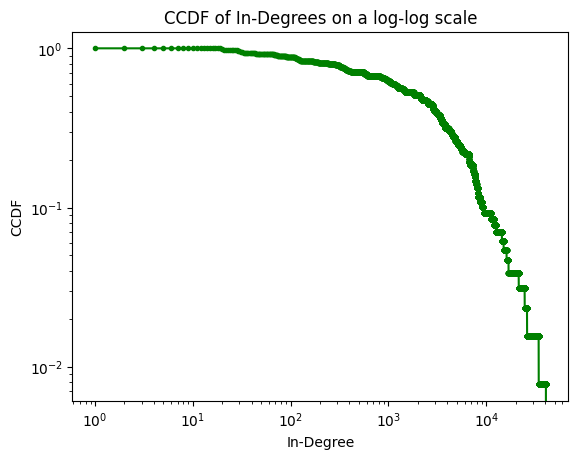

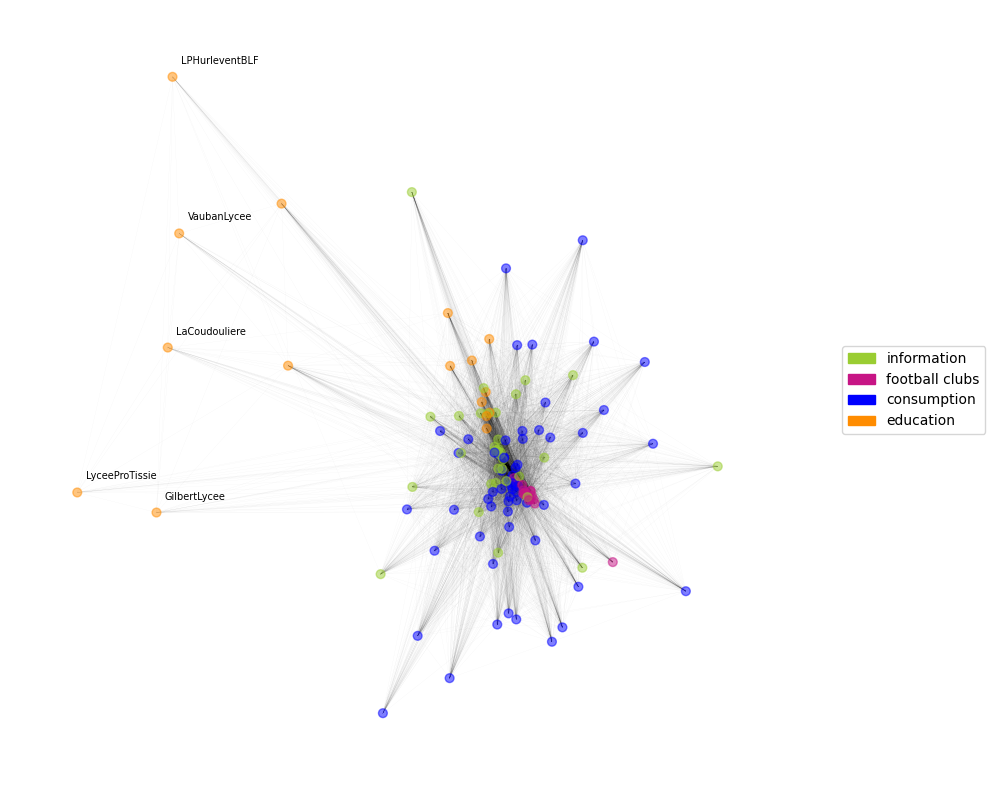

Number of communities: 3
Graph checks complete. Starting CA fitting pipeline...
Creating contingency table...
Performing CA analysis. Might take some time...
Plotting variance...


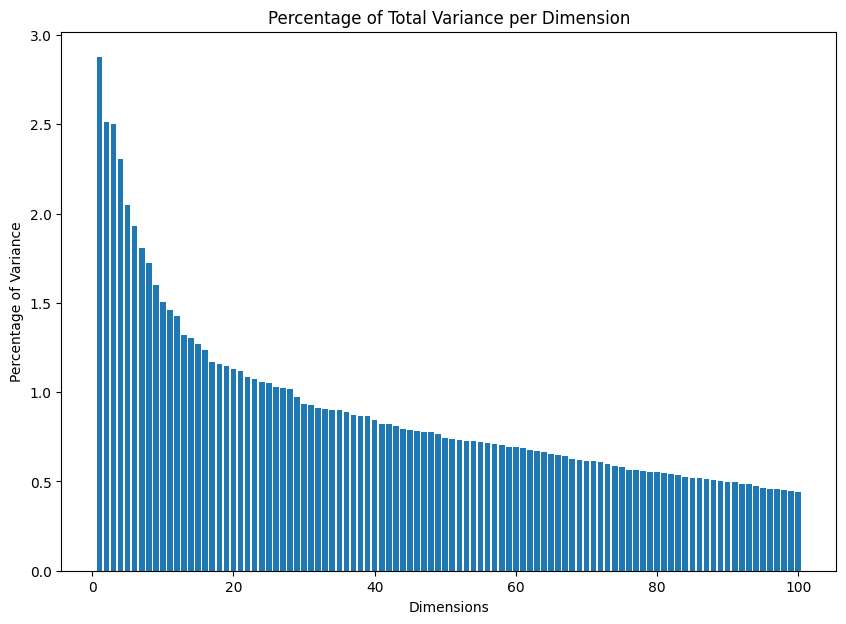

CA pipeline complete.


In [69]:
#m3
importlib.reload(ca_pipeline)
subset_name = 'm3'
labeled = ca_pipeline.PipelineCorAnalysis(m3_df, subset_name)
path = '/home/livtollanes/NewData/coordinates/'
labeled.run_all(path)

Starting graph checks...
Number of nodes: 101996
Edge number is sane - matches the number of rows in the inputted edgelist
Is the graph connected? True
Number of connected components: 1
Size of largest connected component: 101996


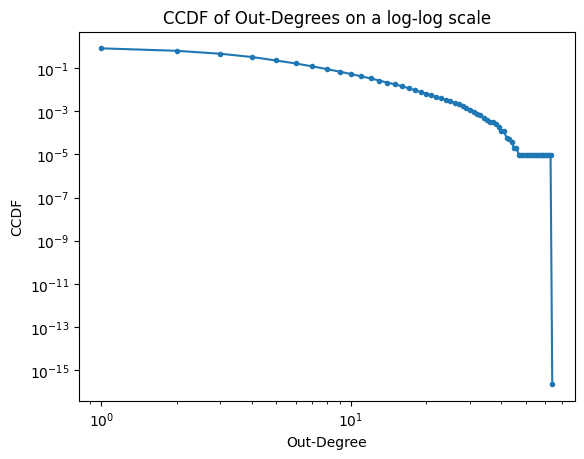

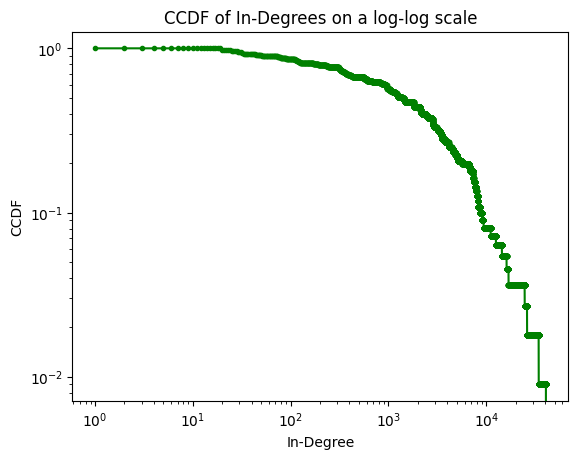

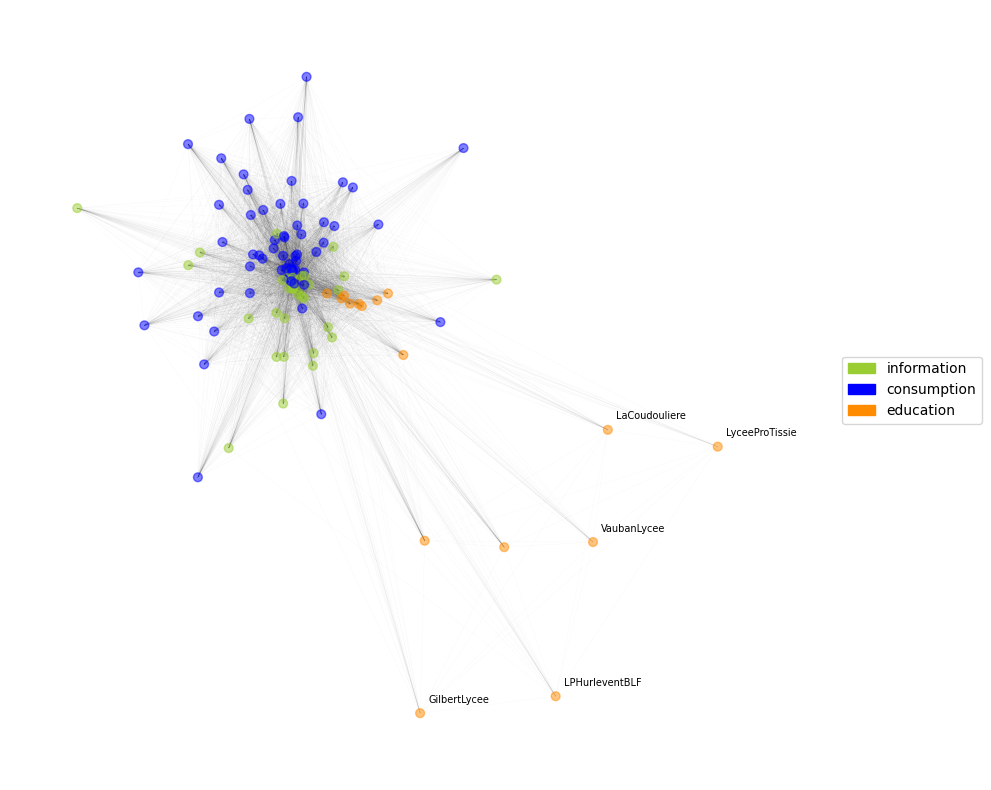

Number of communities: 4
Graph checks complete. Starting CA fitting pipeline...
Creating contingency table...
Performing CA analysis. Might take some time...
Plotting variance...


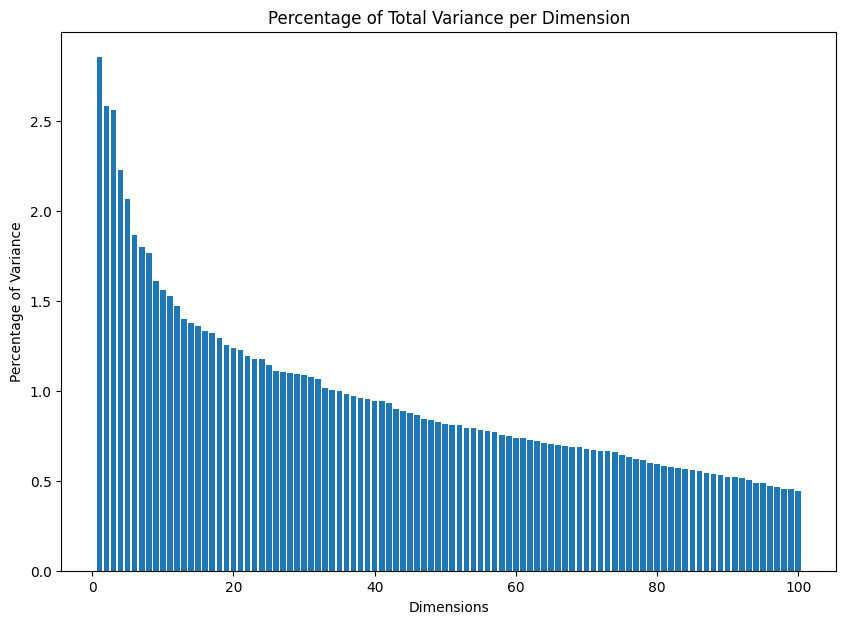

CA pipeline complete.


In [70]:
#m4
importlib.reload(ca_pipeline)
subset_name = 'm4'
labeled = ca_pipeline.PipelineCorAnalysis(m4_df, subset_name)
path = '/home/livtollanes/NewData/coordinates/'
labeled.run_all(path)

Starting graph checks...
Number of nodes: 100748
Edge number is sane - matches the number of rows in the inputted edgelist
Is the graph connected? True
Number of connected components: 1
Size of largest connected component: 100748


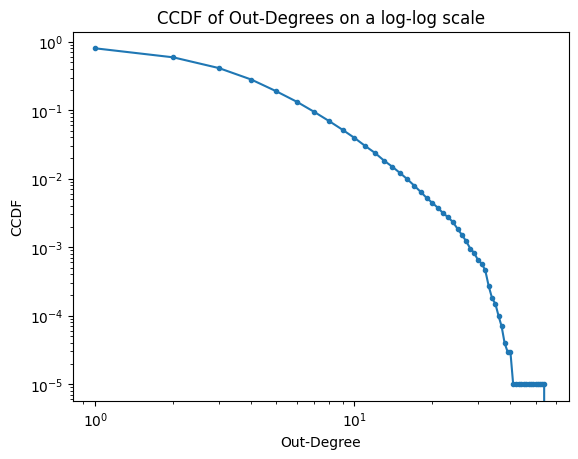

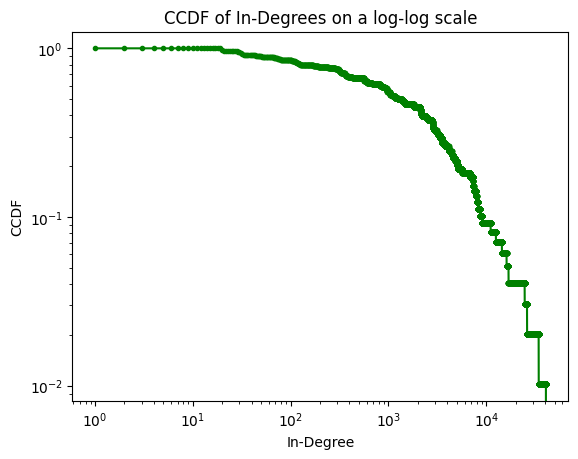

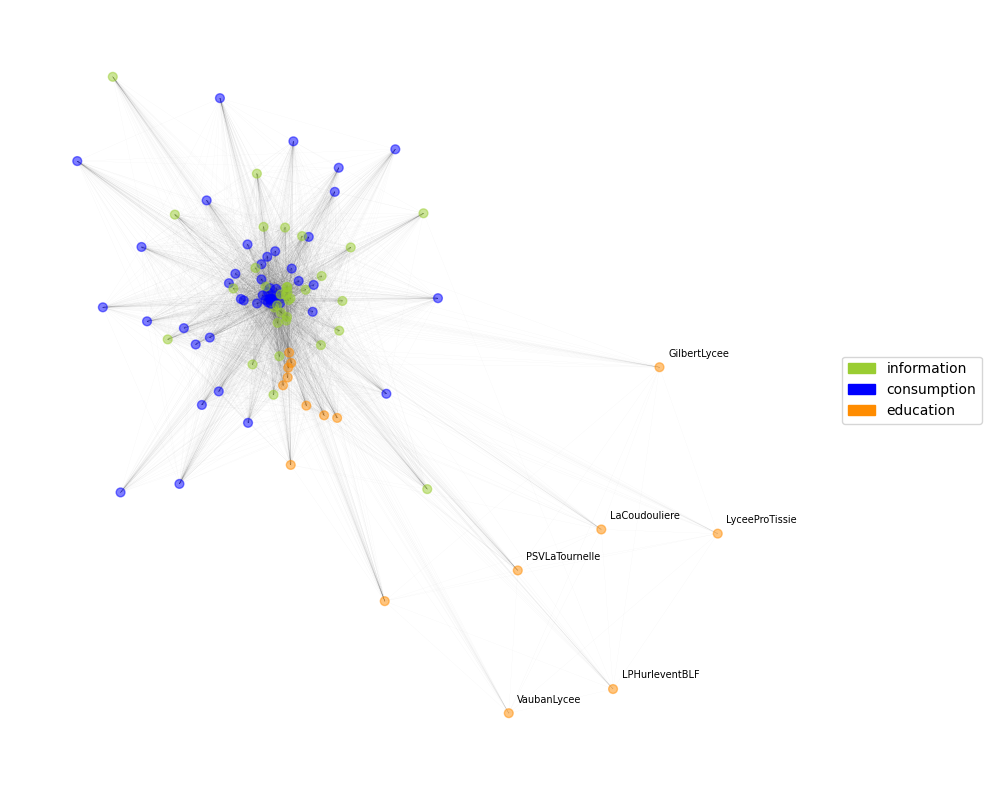

Number of communities: 3
Graph checks complete. Starting CA fitting pipeline...
Creating contingency table...
Performing CA analysis. Might take some time...
Plotting variance...


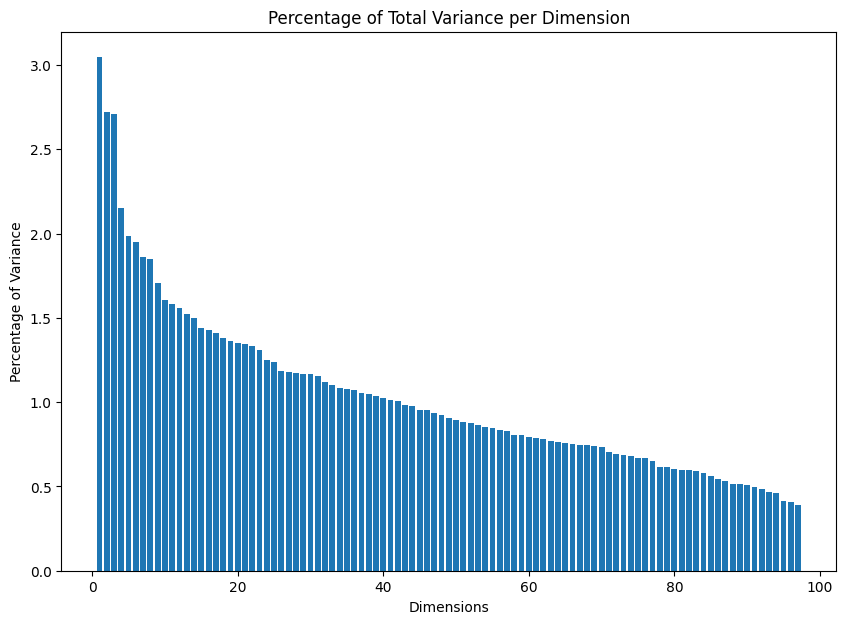

CA pipeline complete.


In [71]:
#m5
importlib.reload(ca_pipeline)
subset_name = 'm5'
labeled = ca_pipeline.PipelineCorAnalysis(m5_df, subset_name)
path = '/home/livtollanes/NewData/coordinates/'
labeled.run_all(path)

Starting graph checks...
Number of nodes: 100973
Edge number is sane - matches the number of rows in the inputted edgelist
Is the graph connected? True
Number of connected components: 1
Size of largest connected component: 100973


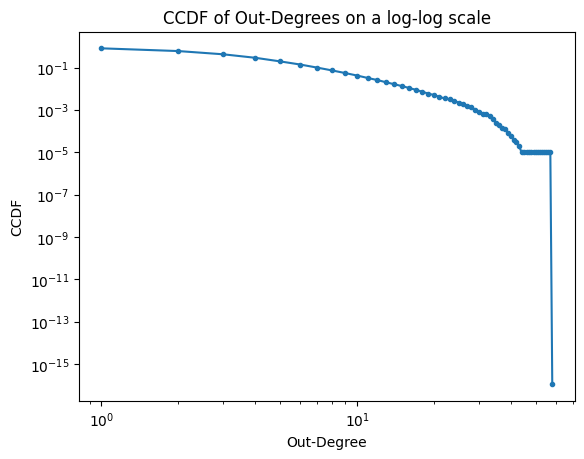

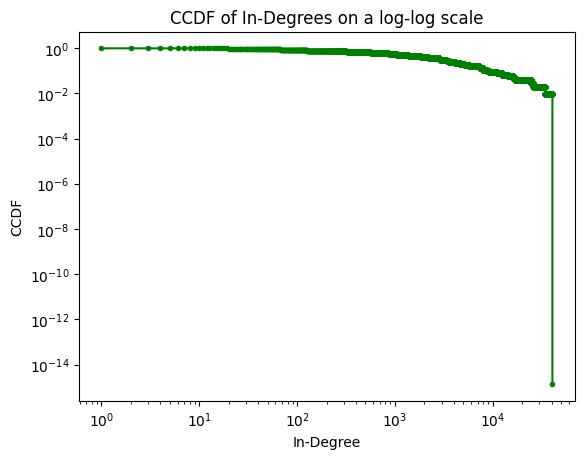

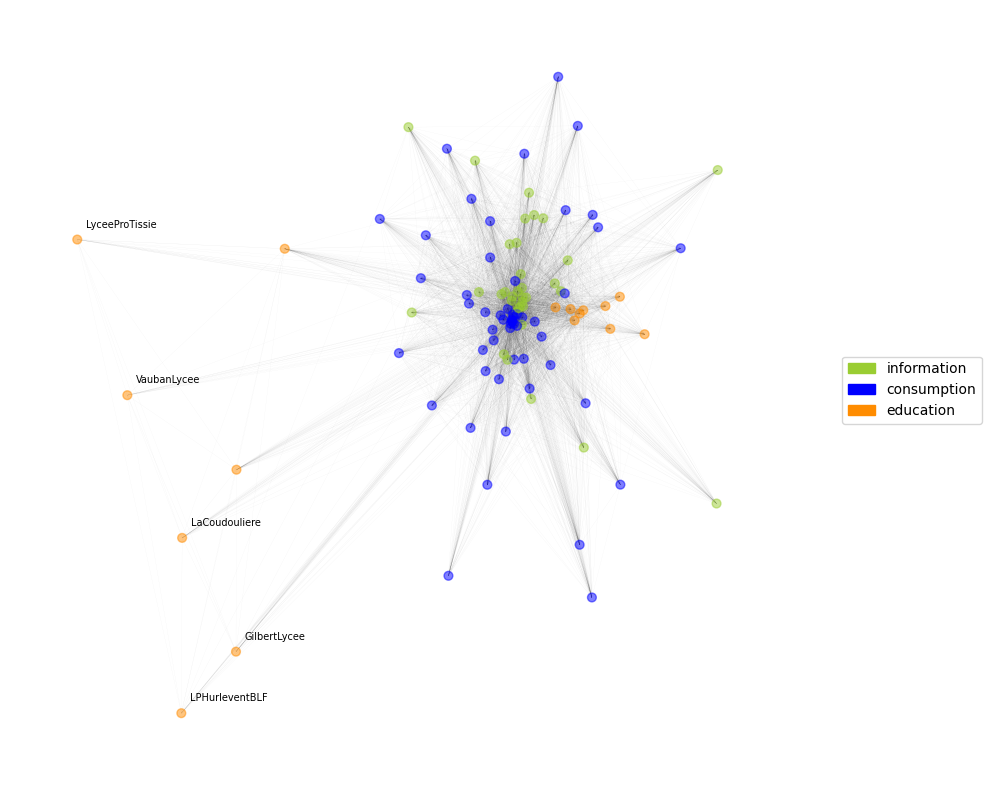

Number of communities: 3
Graph checks complete. Starting CA fitting pipeline...
Creating contingency table...
Performing CA analysis. Might take some time...
Plotting variance...


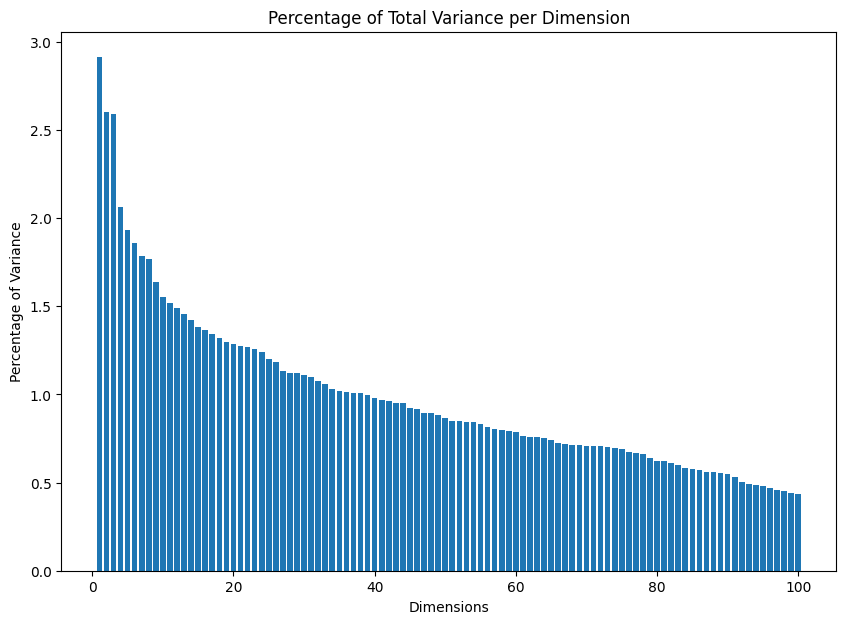

CA pipeline complete.


In [72]:
#m6
importlib.reload(ca_pipeline)
subset_name = 'm6'
labeled = ca_pipeline.PipelineCorAnalysis(m6_df, subset_name)
path = '/home/livtollanes/NewData/coordinates/'
labeled.run_all(path)

Starting graph checks...
Number of nodes: 51383
Edge number is sane - matches the number of rows in the inputted edgelist
Is the graph connected? True
Number of connected components: 1
Size of largest connected component: 51383


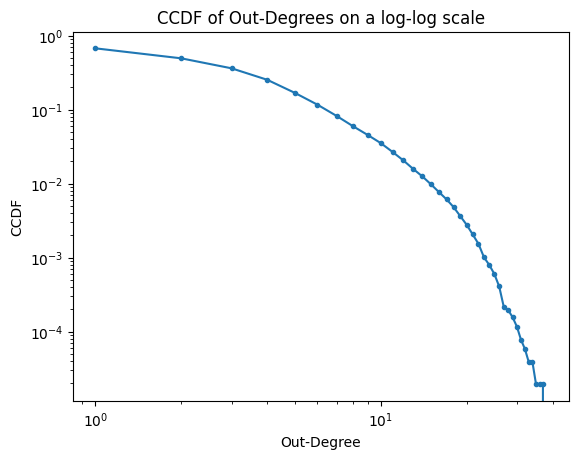

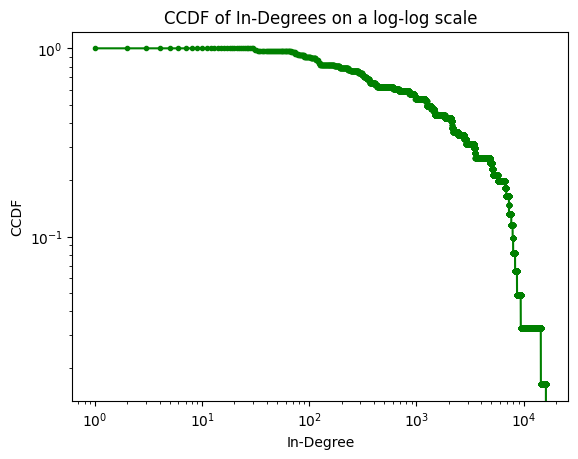

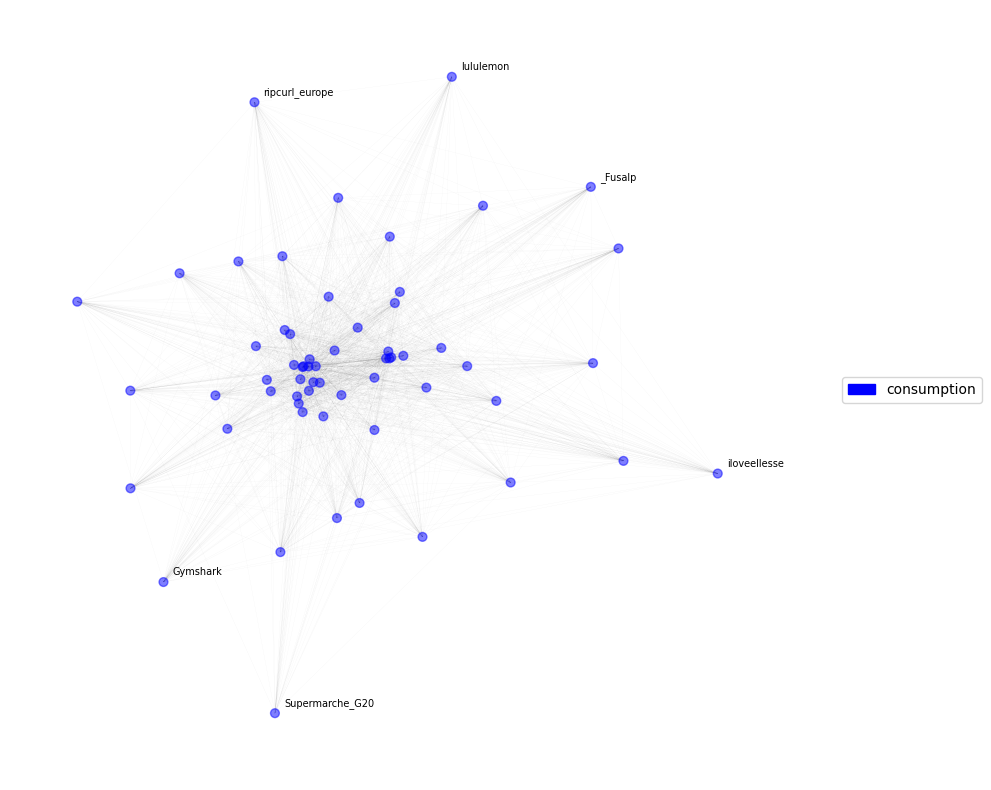

Number of communities: 3
Graph checks complete. Starting CA fitting pipeline...
Creating contingency table...
Performing CA analysis. Might take some time...
Plotting variance...


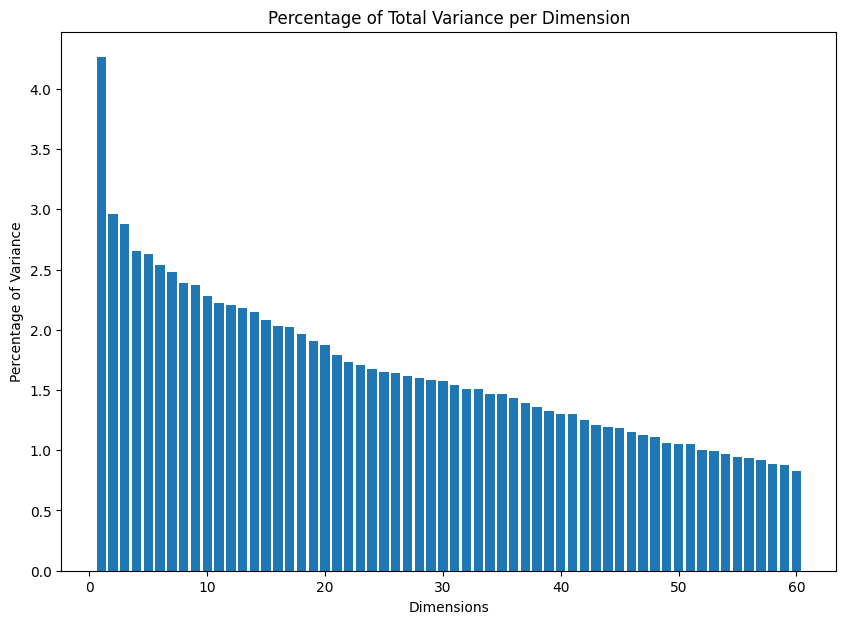

CA pipeline complete.


In [73]:
#m7
importlib.reload(ca_pipeline)
subset_name = 'm7'
labeled = ca_pipeline.PipelineCorAnalysis(m7_df, subset_name)
path = '/home/livtollanes/NewData/coordinates/'
labeled.run_all(path)

Starting graph checks...
Number of nodes: 108905
Edge number is sane - matches the number of rows in the inputted edgelist
Is the graph connected? True
Number of connected components: 1
Size of largest connected component: 108905


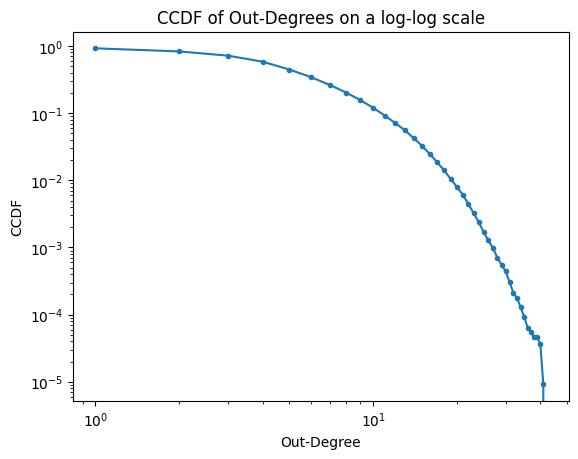

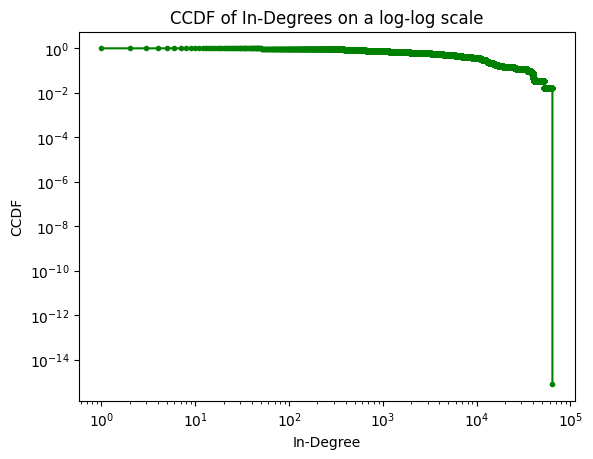

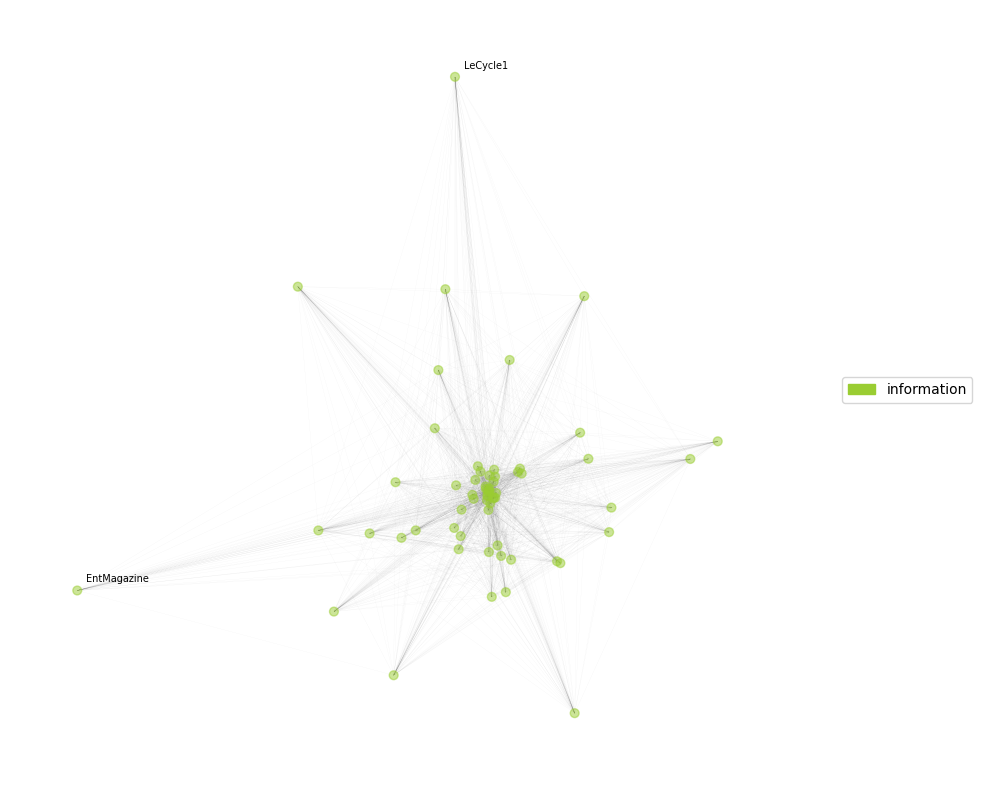

Number of communities: 3
Graph checks complete. Starting CA fitting pipeline...
Creating contingency table...
Performing CA analysis. Might take some time...
Plotting variance...


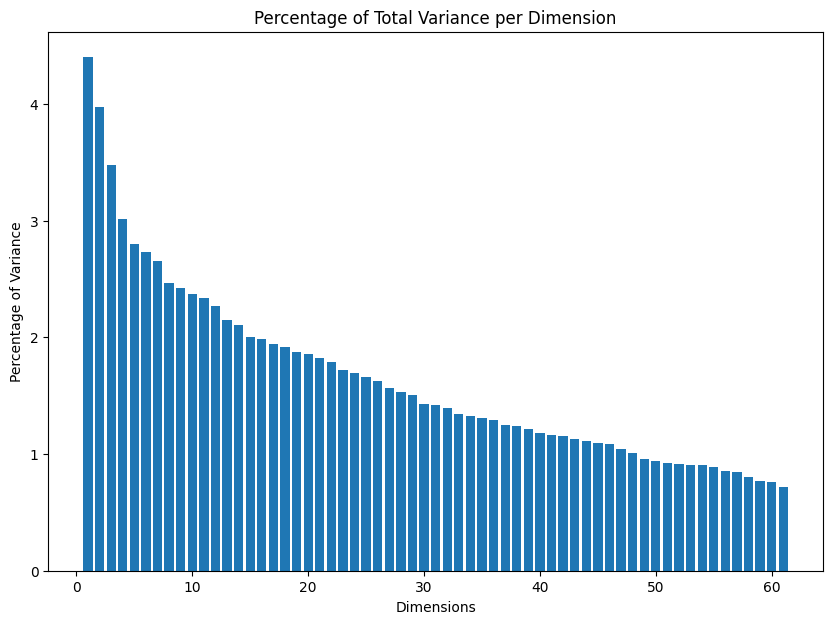

CA pipeline complete.


In [74]:
#m8
importlib.reload(ca_pipeline)
subset_name = 'm8'
labeled = ca_pipeline.PipelineCorAnalysis(m8_df, subset_name)
path = '/home/livtollanes/NewData/coordinates/'
labeled.run_all(path)

Starting graph checks...
Number of nodes: 36633
Edge number is sane - matches the number of rows in the inputted edgelist
Is the graph connected? True
Number of connected components: 1
Size of largest connected component: 36633


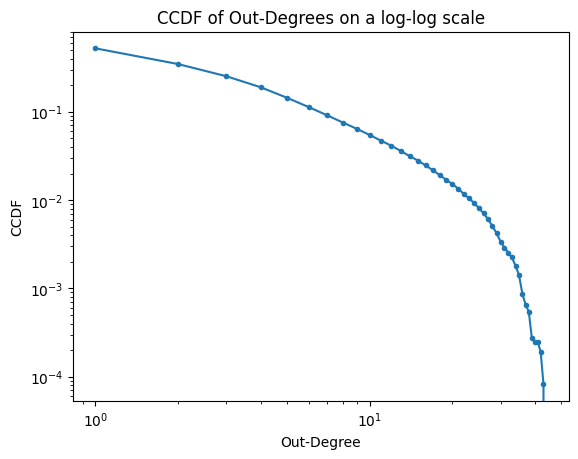

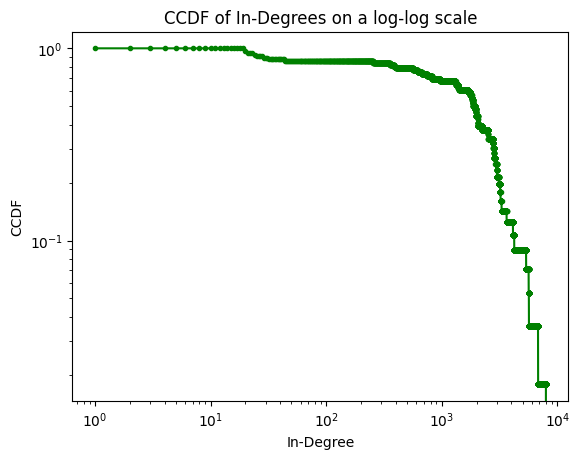

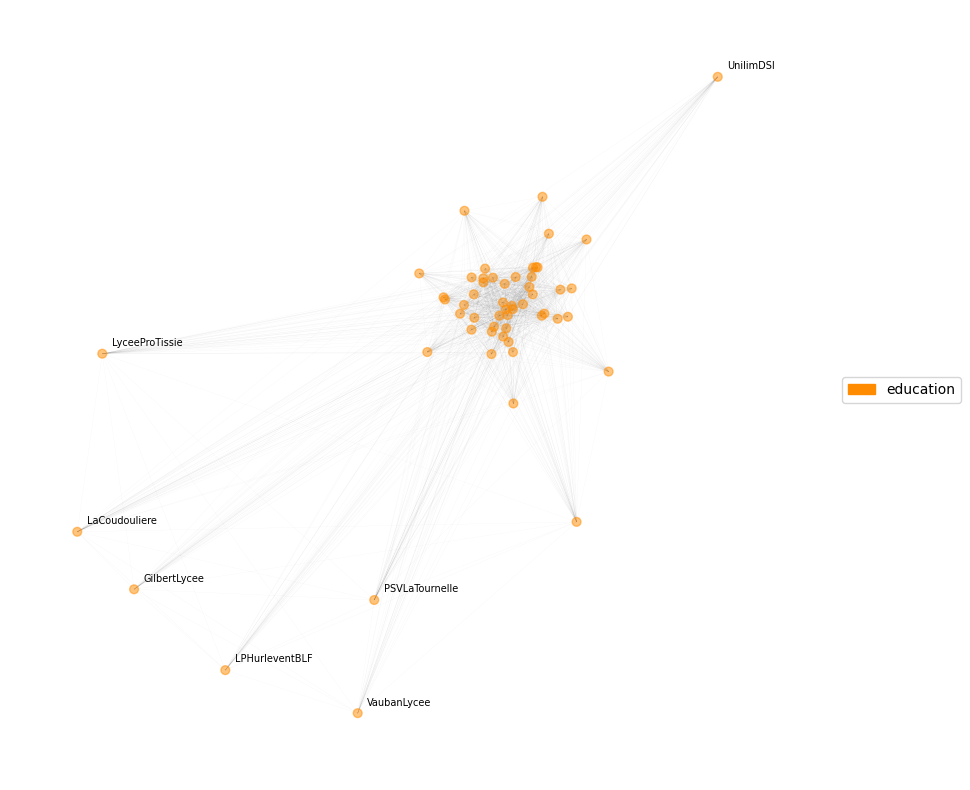

Number of communities: 3
Graph checks complete. Starting CA fitting pipeline...
Creating contingency table...
Performing CA analysis. Might take some time...
Plotting variance...


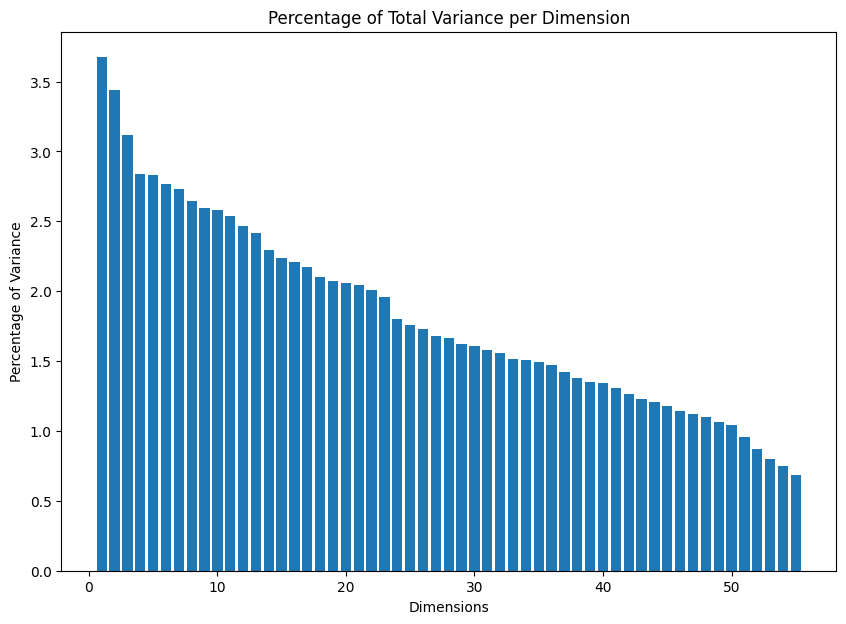

CA pipeline complete.


In [75]:
#m9
importlib.reload(ca_pipeline)
subset_name = 'm9'
labeled = ca_pipeline.PipelineCorAnalysis(m9_df, subset_name)
path = '/home/livtollanes/NewData/coordinates/'
labeled.run_all(path)